In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
signalFile=TFile.Open("samples/sig_nonres_bbzz.root")
backgroundFile=TFile.Open("samples/bkg_ttbar_dilepton.root")

In [3]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  75809
background events number before cut is:  10995


Convert minitree into numpy

In [5]:
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
print(signalArray.shape)

(75809, 22)


In [6]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

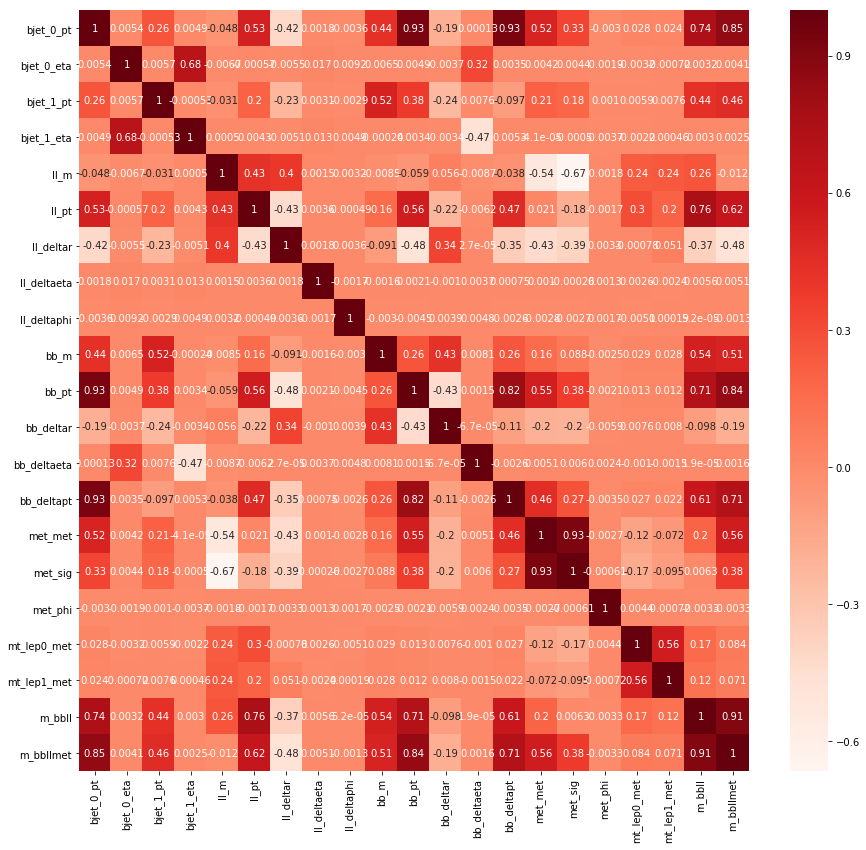

In [7]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

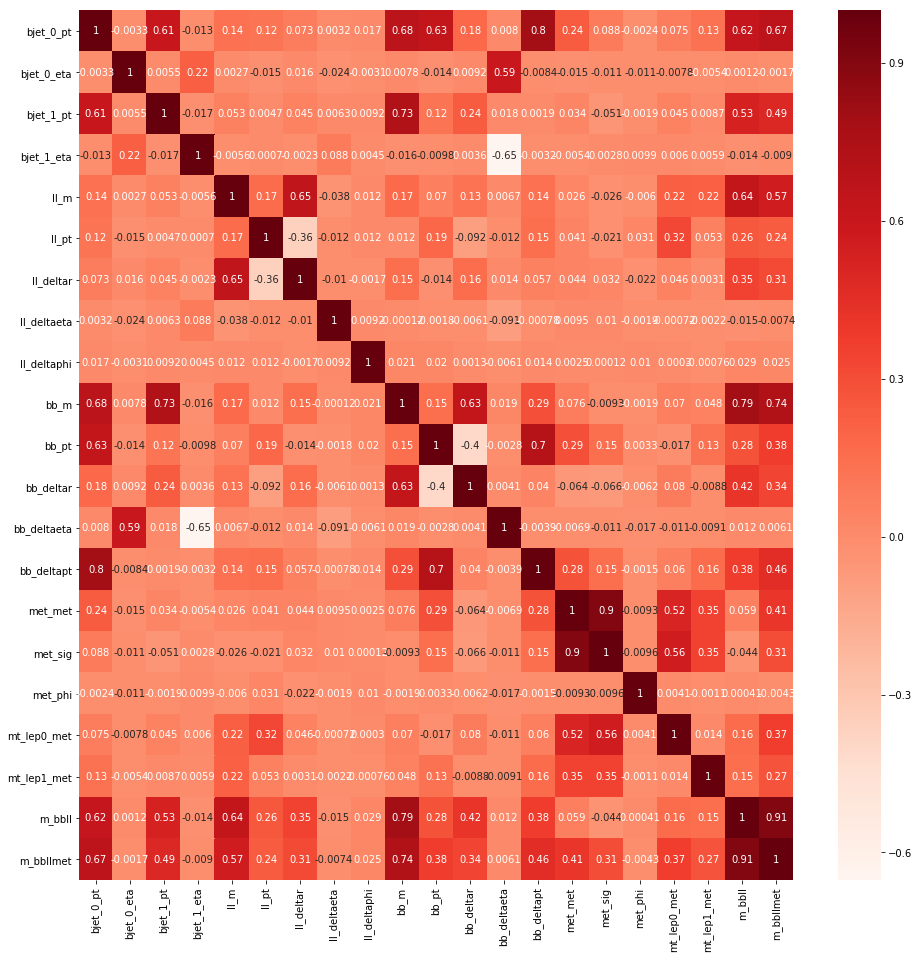

In [8]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



In [9]:
print(signalArray)

[[ 7.44818327e-07  1.06398070e+05 -8.51465642e-01 ...  1.67548516e+04
   4.26808188e+05  4.88755188e+05]
 [ 1.59458984e-07  2.06580719e+05 -1.27479148e+00 ...  5.15779141e+04
   7.98903688e+05  8.56081875e+05]
 [ 8.09472716e-07  1.32475984e+05  3.39121938e-01 ...  1.92662500e+04
   2.89801688e+05  4.88526250e+05]
 ...
 [ 1.65113239e-07  1.02363820e+05  8.04546416e-01 ...  4.17481328e+04
   8.63429250e+05  8.78042938e+05]
 [ 1.93601197e-07  3.54055469e+05 -2.08675280e-01 ...  2.02780938e+04
   7.03278562e+05  8.30059688e+05]
 [-9.16766753e-08  3.64696844e+05  4.29171950e-01 ...  2.43024629e+04
   5.73283750e+05  9.84956125e+05]]


In [10]:
print(signalArray[:,1])

[106398.0703125 206580.71875   132475.984375  ... 102363.8203125
 354055.46875   364696.84375  ]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [11]:
signalSample=signalArray#[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray#[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [12]:
print(len(signalSample))
print(len(backgroundSample))

75809
10995


In [13]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  75809
background event number after cut is: 10995


Split datasets into training and testing subsets

In [14]:
trainingRatio=0.9
sigTrainNum=int(signalNum*0.9)
backgroundTrainNum=int(backgroundNum*0.9)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  68228
testing signal events number is:  7581
training background events number is:  9895
testing background events number is:  1100


In [15]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[0.00000000e+00 2.45408984e-02 1.05561070e+05 ... 1.24413414e+05
  3.20457281e+05 4.01566500e+05]
 [0.00000000e+00 3.02142020e-02 4.53418203e+04 ... 3.99442031e+04
  2.09281391e+05 2.55596703e+05]
 [0.00000000e+00 3.43414116e-02 1.81585859e+05 ... 2.07334297e+05
  4.67148344e+05 6.32169188e+05]
 ...
 [0.00000000e+00 5.77727809e-02 8.80232734e+04 ... 5.17151562e+04
  2.23507344e+05 3.77380344e+05]
 [0.00000000e+00 5.34303509e-02 7.04268359e+04 ... 6.41056406e+04
  2.78355688e+05 3.67629312e+05]
 [0.00000000e+00 4.76664438e-02 1.04544781e+05 ... 8.39545000e+04
  2.79220312e+05 3.78958656e+05]]
7.867899370347196e-05


In [16]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(78123, 21) dtype=float32>

Signal and background training sets should have same yield in training

(78123,)
(78123,)


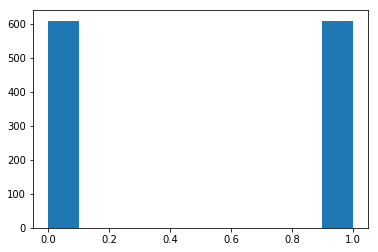

In [17]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [18]:
traindf=pd.DataFrame(data=dataTrainSample)
normalize_df=(traindf-traindf.min())/(traindf.max()-traindf.min())
dataTrainSample1=normalize_df.values
print(dataTrainSample1)

[[0.12225475 0.30745999 0.04277629 ... 0.01370752 0.11458257 0.14457262]
 [0.14629091 0.47571232 0.0126986  ... 0.02478187 0.11080131 0.11688107]
 [0.07585962 0.42984231 0.0443754  ... 0.02934198 0.10202535 0.13044608]
 ...
 [0.05875616 0.43743239 0.03422648 ... 0.04658775 0.06046667 0.06170444]
 [0.03912855 0.24907141 0.01751522 ... 0.02183919 0.13081664 0.12277772]
 [0.16002799 0.39824324 0.03684254 ... 0.01035595 0.06177372 0.14567832]]


In [19]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     #optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
      optimizer='adam',
     metrics=["acc"])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [21]:
model.save('model_HHZZ.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
__________

2019-06-21 01:42:16.060666: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-06-21 01:42:16.064392: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2019-06-21 01:42:16.064954: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55994c463b00 executing computations on platform Host. Devices:
2019-06-21 01:42:16.064968: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-21 01:42:16.129085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-21 01:42:16.129405: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55994c512bc0 executing computations on platform CUDA. Devices:
2019-06-21 01:42:16.129418: I t

In [22]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
78123/78123 [==============================] - 12s 149us/sample - loss: 0.4474 - acc: 0.9017
Epoch 2/30
78123/78123 [==============================] - 9s 112us/sample - loss: 0.4536 - acc: 0.9081
Epoch 3/30
78123/78123 [==============================] - 10s 125us/sample - loss: 0.4045 - acc: 0.9190
Epoch 4/30
78123/78123 [==============================] - 11s 137us/sample - loss: 0.3283 - acc: 0.9348
Epoch 5/30
78123/78123 [==============================] - 10s 126us/sample - loss: 0.3095 - acc: 0.9372
Epoch 6/30
78123/78123 [==============================] - 9s 114us/sample - loss: 0.3043 - acc: 0.9386
Epoch 7/30
78123/78123 [==============================] - 9s 118us/sample - loss: 0.2956 - acc: 0.9429
Epoch 8/30
78123/78123 [==============================] - 9s 118us/sample - loss: 0.2726 - acc: 0.9484
Epoch 9/30
78123/78123 [==============================] - 9s 120us/sample - loss: 0.2555 - acc: 0.9519
Epoch 10/30
78123/781

2019-06-21 01:42:19.407608: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


In [23]:
signaldf=pd.DataFrame(data=signalSample[:,1:])
normalize_df=(signaldf-signaldf.min())/(signaldf.max()-signaldf.min())
signalSample1=normalize_df.values
print(dataTrainSample1)
backgrounddf=pd.DataFrame(data=backgroundSample[:,1:])
normalize_df=(backgrounddf-backgrounddf.min())/(backgrounddf.max()-backgrounddf.min())
backgroundSample1=normalize_df.values
print(backgroundSample1)

[[0.12225475 0.30745999 0.04277629 ... 0.01370752 0.11458257 0.14457262]
 [0.14629091 0.47571232 0.0126986  ... 0.02478187 0.11080131 0.11688107]
 [0.07585962 0.42984231 0.0443754  ... 0.02934198 0.10202535 0.13044608]
 ...
 [0.05875616 0.43743239 0.03422648 ... 0.04658775 0.06046667 0.06170444]
 [0.03912855 0.24907141 0.01751522 ... 0.02183919 0.13081664 0.12277772]
 [0.16002799 0.39824324 0.03684254 ... 0.01035595 0.06177372 0.14567832]]
[[0.1048238  0.50330782 0.08915562 ... 0.0885143  0.09467147 0.07783742]
 [0.19377055 0.29564217 0.24111472 ... 0.3229771  0.30668546 0.2640282 ]
 [0.04893508 0.73308935 0.04601364 ... 0.19212414 0.05945254 0.06798196]
 ...
 [0.13033736 0.76843606 0.00194335 ... 0.03767111 0.22142912 0.16110338]
 [0.0810195  0.34781338 0.04074328 ... 0.05596303 0.1327359  0.10465274]
 [0.09606173 0.32056755 0.14051585 ... 0.19238532 0.11342759 0.11192518]]


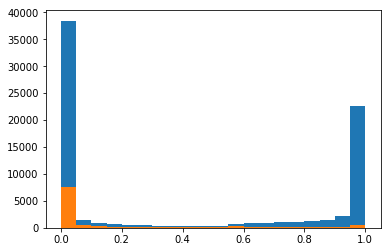

In [24]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

(array([7648.,  485.,  299.,  196.,  166.,  129.,  118.,  114.,   89.,
          80.,   69.,  250.,   97.,   95.,  121.,  102.,   99.,  114.,
         143.,  581.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

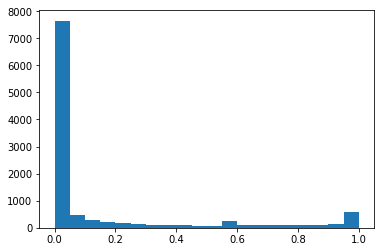

In [25]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [26]:
model.save('model_HHZZ.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
__________

In [27]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

[[9.9292362e-01]
 [3.1776783e-01]
 [5.1094264e-01]
 ...
 [3.8738847e-03]
 [9.3966722e-05]
 [1.0000000e+00]]


(array([38436.,  1381.,   851.,   618.,   513.,   448.,   369.,   335.,
          317.,   302.,   282.,   634.,   815.,   956.,   996.,  1068.,
         1207.,  1458.,  2146., 22677.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

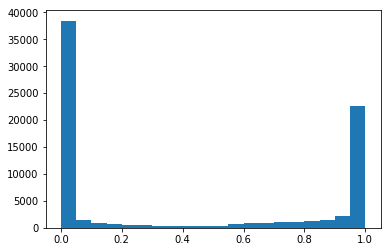

In [28]:
plt.hist(signalNNScore,bins=20)

In [29]:
cuda.select_device(0)
cuda.close()

In [30]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varName)
param = {'max_depth': 7, 'eta': 0.6, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [31]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.956062	train-auc:0.955687
[1]	eval-auc:0.972458	train-auc:0.971479
[2]	eval-auc:0.978307	train-auc:0.978037
[3]	eval-auc:0.980458	train-auc:0.981183
[4]	eval-auc:0.982692	train-auc:0.983491
[5]	eval-auc:0.983424	train-auc:0.984993
[6]	eval-auc:0.984582	train-auc:0.985995
[7]	eval-auc:0.984761	train-auc:0.987038
[8]	eval-auc:0.985159	train-auc:0.987769
[9]	eval-auc:0.98522	train-auc:0.988528
[10]	eval-auc:0.985472	train-auc:0.989225
[11]	eval-auc:0.985176	train-auc:0.989757
[12]	eval-auc:0.985438	train-auc:0.99026
[13]	eval-auc:0.98521	train-auc:0.990991
[14]	eval-auc:0.985363	train-auc:0.991566
[15]	eval-auc:0.985522	train-auc:0.991982
[16]	eval-auc:0.985852	train-auc:0.992637
[17]	eval-auc:0.985932	train-auc:0.992952
[18]	eval-auc:0.985907	train-auc:0.993344
[19]	eval-auc:0.985835	train-auc:0.993806
[20]	eval-auc:0.98526	train-auc:0.994295
[21]	eval-auc:0.985482	train-auc:0.994677
[22]	eval-auc:0.98509	train-auc:0.994896
[23]	eval-auc:0.984452	train-auc:0.995473
[24]	ev

[198]	eval-auc:0.974697	train-auc:1.01773
[199]	eval-auc:0.974352	train-auc:1.01775
[200]	eval-auc:0.974412	train-auc:1.01788
[201]	eval-auc:0.97441	train-auc:1.01799
[202]	eval-auc:0.974304	train-auc:1.01805
[203]	eval-auc:0.974298	train-auc:1.0182
[204]	eval-auc:0.974516	train-auc:1.01799
[205]	eval-auc:0.974164	train-auc:1.01816
[206]	eval-auc:0.974011	train-auc:1.01815
[207]	eval-auc:0.973338	train-auc:1.01828
[208]	eval-auc:0.973522	train-auc:1.01827
[209]	eval-auc:0.973547	train-auc:1.01835
[210]	eval-auc:0.973052	train-auc:1.01842
[211]	eval-auc:0.972751	train-auc:1.01851
[212]	eval-auc:0.973089	train-auc:1.01844
[213]	eval-auc:0.973324	train-auc:1.01839
[214]	eval-auc:0.9733	train-auc:1.01852
[215]	eval-auc:0.972978	train-auc:1.01866
[216]	eval-auc:0.973114	train-auc:1.01859
[217]	eval-auc:0.973208	train-auc:1.0187
[218]	eval-auc:0.973	train-auc:1.0187
[219]	eval-auc:0.973268	train-auc:1.01881
[220]	eval-auc:0.972865	train-auc:1.01888
[221]	eval-auc:0.972549	train-auc:1.01911
[

[395]	eval-auc:0.963566	train-auc:1.02685
[396]	eval-auc:0.9635	train-auc:1.0269
[397]	eval-auc:0.963722	train-auc:1.02688
[398]	eval-auc:0.963911	train-auc:1.02677
[399]	eval-auc:0.963805	train-auc:1.0268
[400]	eval-auc:0.964191	train-auc:1.02665
[401]	eval-auc:0.964053	train-auc:1.02668
[402]	eval-auc:0.964362	train-auc:1.02666
[403]	eval-auc:0.964072	train-auc:1.02675
[404]	eval-auc:0.964213	train-auc:1.02669
[405]	eval-auc:0.964427	train-auc:1.02672
[406]	eval-auc:0.964537	train-auc:1.02675
[407]	eval-auc:0.964304	train-auc:1.02679
[408]	eval-auc:0.964292	train-auc:1.02686
[409]	eval-auc:0.964097	train-auc:1.02696
[410]	eval-auc:0.963925	train-auc:1.02705
[411]	eval-auc:0.963792	train-auc:1.02704
[412]	eval-auc:0.963719	train-auc:1.02705
[413]	eval-auc:0.964085	train-auc:1.02713
[414]	eval-auc:0.964091	train-auc:1.02716
[415]	eval-auc:0.964002	train-auc:1.02723
[416]	eval-auc:0.963953	train-auc:1.0273
[417]	eval-auc:0.963837	train-auc:1.02737
[418]	eval-auc:0.963879	train-auc:1.027

[592]	eval-auc:0.956222	train-auc:1.03066
[593]	eval-auc:0.956392	train-auc:1.03064
[594]	eval-auc:0.956448	train-auc:1.03066
[595]	eval-auc:0.955902	train-auc:1.03065
[596]	eval-auc:0.955854	train-auc:1.03069
[597]	eval-auc:0.955371	train-auc:1.03068
[598]	eval-auc:0.955488	train-auc:1.0307
[599]	eval-auc:0.955395	train-auc:1.03068
[600]	eval-auc:0.955254	train-auc:1.03069
[601]	eval-auc:0.954871	train-auc:1.03074
[602]	eval-auc:0.955087	train-auc:1.03076
[603]	eval-auc:0.955217	train-auc:1.03085
[604]	eval-auc:0.955405	train-auc:1.03085
[605]	eval-auc:0.955454	train-auc:1.03081
[606]	eval-auc:0.955211	train-auc:1.03081
[607]	eval-auc:0.955504	train-auc:1.03084
[608]	eval-auc:0.95577	train-auc:1.03086
[609]	eval-auc:0.955939	train-auc:1.03088
[610]	eval-auc:0.955609	train-auc:1.03091
[611]	eval-auc:0.955375	train-auc:1.03098
[612]	eval-auc:0.955191	train-auc:1.03097
[613]	eval-auc:0.954976	train-auc:1.031
[614]	eval-auc:0.954931	train-auc:1.031
[615]	eval-auc:0.955294	train-auc:1.0310

[789]	eval-auc:0.951162	train-auc:1.03335
[790]	eval-auc:0.951326	train-auc:1.03336
[791]	eval-auc:0.951403	train-auc:1.03337
[792]	eval-auc:0.951214	train-auc:1.0334
[793]	eval-auc:0.951088	train-auc:1.03344
[794]	eval-auc:0.951331	train-auc:1.03337
[795]	eval-auc:0.950832	train-auc:1.03341
[796]	eval-auc:0.95118	train-auc:1.03341
[797]	eval-auc:0.951056	train-auc:1.03343
[798]	eval-auc:0.950857	train-auc:1.03344
[799]	eval-auc:0.950983	train-auc:1.03338
[800]	eval-auc:0.95047	train-auc:1.03341
[801]	eval-auc:0.950587	train-auc:1.03337
[802]	eval-auc:0.950481	train-auc:1.0334
[803]	eval-auc:0.950562	train-auc:1.03337
[804]	eval-auc:0.950429	train-auc:1.03336
[805]	eval-auc:0.950374	train-auc:1.03335
[806]	eval-auc:0.950193	train-auc:1.03339
[807]	eval-auc:0.950057	train-auc:1.03349
[808]	eval-auc:0.950339	train-auc:1.0335
[809]	eval-auc:0.950609	train-auc:1.0335
[810]	eval-auc:0.950292	train-auc:1.03351
[811]	eval-auc:0.950548	train-auc:1.03348
[812]	eval-auc:0.950629	train-auc:1.0334

[986]	eval-auc:0.945861	train-auc:1.03521
[987]	eval-auc:0.946045	train-auc:1.03514
[988]	eval-auc:0.945938	train-auc:1.03511
[989]	eval-auc:0.945997	train-auc:1.03511
[990]	eval-auc:0.945938	train-auc:1.03514
[991]	eval-auc:0.945662	train-auc:1.03514
[992]	eval-auc:0.94572	train-auc:1.03515
[993]	eval-auc:0.945672	train-auc:1.03515
[994]	eval-auc:0.945786	train-auc:1.03515
[995]	eval-auc:0.945862	train-auc:1.03515
[996]	eval-auc:0.94572	train-auc:1.03516
[997]	eval-auc:0.945863	train-auc:1.03516
[998]	eval-auc:0.945751	train-auc:1.03516
[999]	eval-auc:0.945519	train-auc:1.03515


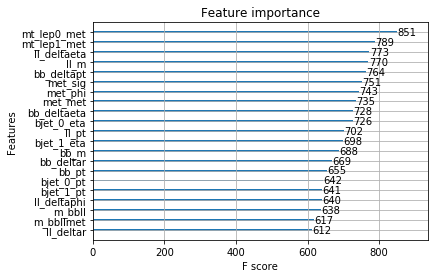

In [32]:
xgb.plot_importance(GBDT)

(array([9960.,  215.,  119.,   90.,   59.,   51.,   52.,   38.,   42.,
          31.,   37.,   31.,   19.,   19.,   28.,   25.,   16.,   19.,
          30.,  114.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

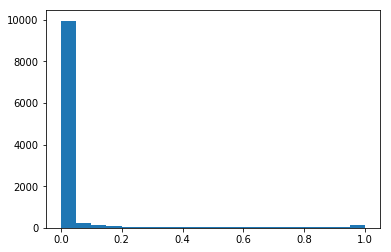

In [33]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20)

(array([ 1403.,   142.,   121.,   118.,    97.,   105.,   107.,   109.,
          108.,   134.,   144.,   140.,   170.,   191.,   218.,   235.,
          303.,   404.,   627., 70933.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

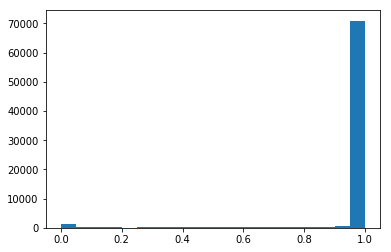

In [34]:
plt.hist(SignalScore,bins=20)

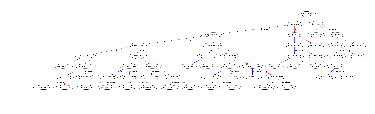

In [35]:
plot_tree(GBDT, num_trees=4)

(array([10132.,   324.,   223.,   178.,   141.,   142.,   146.,   132.,
          136.,   157.,   164.,   156.,   180.,   193.,   230.,   230.,
          301.,   399.,   603., 63956.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

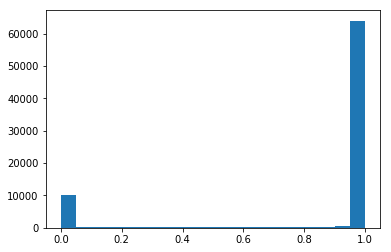

In [36]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [37]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

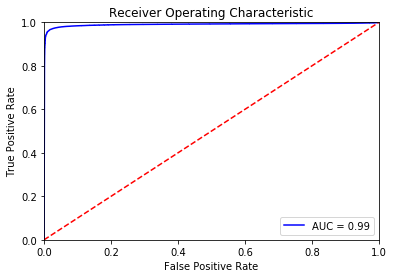

In [38]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

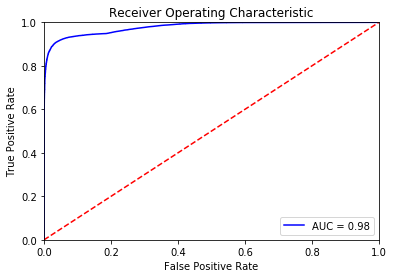

In [39]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
pickle.dump(GBDT, open("GBDT_HHzz.pickle.dat", "wb"))

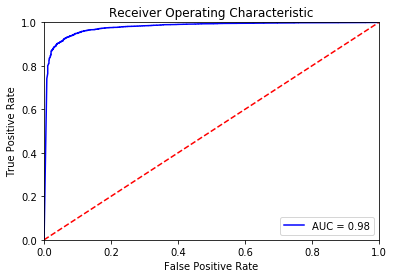

In [41]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()